## 1. Imports and Setup

In [49]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import pandas as pd
import os
from tensorflow.keras import layers
import keras
from keras import layers

with open("resources/jena_climate_2009_2016.csv", 'r') as file: data = file.read()

## 2. Parsing the Data

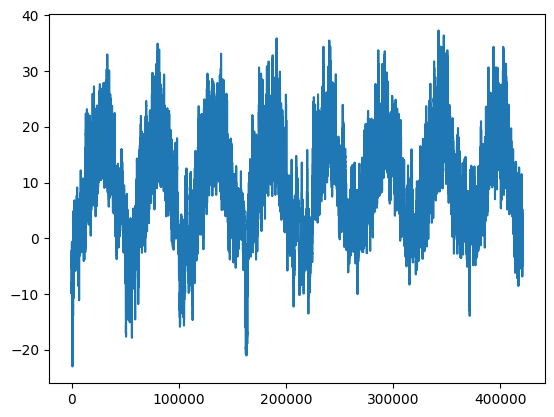

In [50]:
header = data.split("\n")[0].split(",")
lines = data.split("\n")[1:]

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

plt.plot(range(len(temperature)), temperature)

## 3. Split the Data

In [51]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = int(0.25 * len(raw_data))

## 4. Normalize the Data (Z-Score)

Z-Score Calculation: $ \frac{x-\mu }{\sigma } $

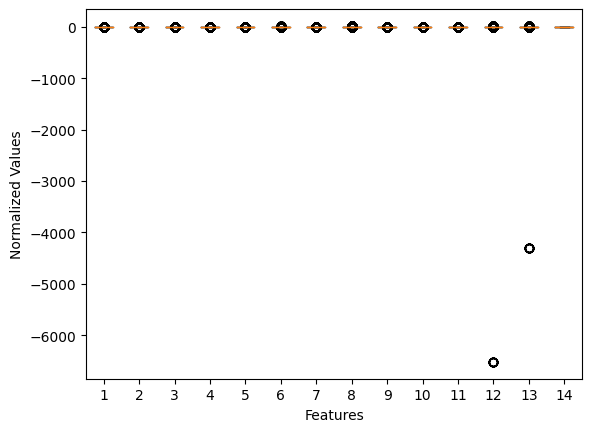

In [52]:
mean = raw_data[:num_train_samples].mean(axis=0)
std = raw_data[:num_train_samples].std(axis=0)

raw_data -= mean
raw_data /= std

plt.boxplot(raw_data)
plt.xlabel('Features')
plt.ylabel('Normalized Values')
plt.show()

## 5. Prepare data for training & testing

Data: The dataset you are working with

Targets: What you want the model to try and predict

Sampling rate: Data points per unit of time

Sequence length: # of previous time steps used as inputs to predict next step

Shuffle: Randomly shuffle the data during training to introduce randomness

Batch size: Number of samples in each batch of the dataset (computational speed vs cpu load)

Start index: Starting index of the dataset

End index: Ending index of the dataset

Delay: Gap between end of sequence and target

In [53]:
batch_size = 256
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


2023-07-25 23:04:25.327033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [210275]
	 [[{{node Placeholder/_20}}]]
2023-07-25 23:04:25.327681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [210275,14]
	 [[{{node Placeholder/_0}}]]


## 6. A Dropout-Regularized LSTM Model

Epoch 1/10
819/819 [==============================] - ETA: 0s - loss: 26.6897 - mae: 3.8193

2023-07-25 23:05:34.790265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-25 23:05:34.790993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [105137]
	 [[{{node Placeholder/_20}}]]


819/819 [==============================] - 80s 94ms/step - loss: 26.6897 - mae: 3.8193 - val_loss: 9.5767 - val_mae: 2.4067
Epoch 2/10
819/819 [==============================] - 92s 112ms/step - loss: 14.7011 - mae: 2.9749 - val_loss: 9.5762 - val_mae: 2.4128
Epoch 3/10
819/819 [==============================] - 87s 106ms/step - loss: 13.8065 - mae: 2.8791 - val_loss: 9.2744 - val_mae: 2.3745
Epoch 4/10
819/819 [==============================] - 92s 111ms/step - loss: 13.1390 - mae: 2.8082 - val_loss: 9.1633 - val_mae: 2.3486
Epoch 5/10
819/819 [==============================] - 95s 115ms/step - loss: 12.7411 - mae: 2.7671 - val_loss: 9.2445 - val_mae: 2.3636
Epoch 6/10
819/819 [==============================] - 92s 112ms/step - loss: 12.3288 - mae: 2.7215 - val_loss: 9.3616 - val_mae: 2.3875
Epoch 7/10
819/819 [==============================] - 96s 117ms/step - loss: 12.0955 - mae: 2.6949 - val_loss: 9.2888 - val_mae: 2.3686
Epoch 8/10
819/819 [==============================] - 91s 11

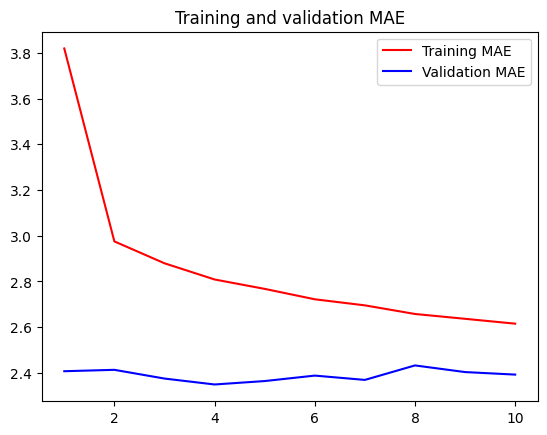

In [54]:
# Define the model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
outputs = layers.Dense(1)(layers.Dropout(0.5)(layers.LSTM(32, recurrent_dropout=0.25)(inputs)))

model = keras.Model(inputs, outputs)

# Keep best version of the model during training, and prepare model for training
callbacks = [keras.callbacks.ModelCheckpoint("models/jena_lstm_dropout.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

# Access the completed model
model = keras.models.load_model("models/jena_lstm_dropout.keras")

# Plot the training and validation MAE
test_mae = history.history["mae"]
val_mae = history.history["val_mae"]
epochs = range(1, len(test_mae) + 1)

plt.figure()
plt.plot(epochs, test_mae, "r", label="Training MAE")
plt.plot(epochs, val_mae, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 7. Test the Model

2023-07-25 23:19:37.829458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [103562]
	 [[{{node Placeholder/_8}}]]
2023-07-25 23:19:37.831551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [104281,14]
	 [[{{node Placeholder/_0}}]]


405/405 [==============================] - 14s 32ms/step - loss: 10.5326 - mae: 2.5529
Test Loss: 10.5326, Test MAE: 2.5529
405/405 [==============================] - 14s 33ms/step


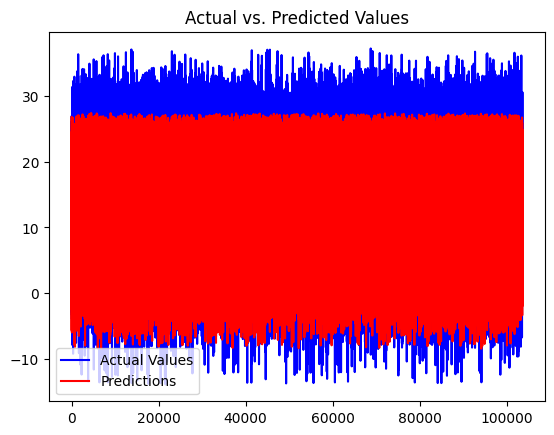

In [55]:
# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Make predictions on the test dataset
test_predictions = model.predict(test_dataset)

# Flatten the test targets and predictions if necessary
test_targets = np.concatenate([y for x, y in test_dataset], axis=0).flatten()
test_predictions = test_predictions.flatten()

# Plot the predictions against the actual values
plt.figure()
plt.plot(test_targets, "b", label="Actual Values")
plt.plot(test_predictions, "r", label="Predictions")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()


## Extra Code

405/405 [==============================] - 12s 27ms/step - loss: 10.5326 - mae: 2.5529
Test Loss: 10.5326, Test MAE: 2.5529
5/5 [==============================] - 1s 13ms/step


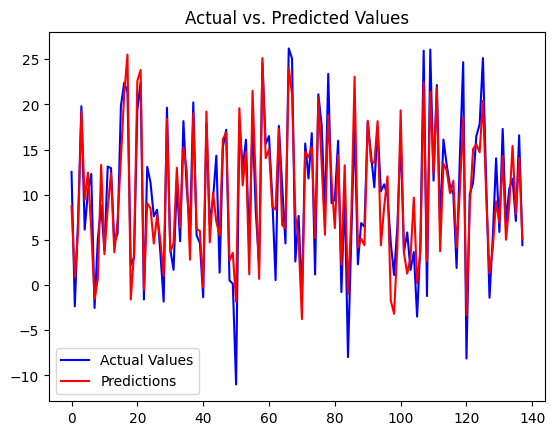

In [56]:
# Load the trained model
model = keras.models.load_model("models/jena_lstm_dropout.keras")

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Optionally, visualize the predictions on the test dataset
# Assuming your test dataset contains both input sequences and target values
for batch in test_dataset:
    test_inputs = batch[0]
    test_targets = batch[1]

# Make predictions on the test inputs
test_predictions = model.predict(test_inputs)

# Optionally, plot the predictions against the actual values
plt.figure()
plt.plot(test_targets, "b", label="Actual Values")
plt.plot(test_predictions, "r", label="Predictions")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()